In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

from google.colab import files
uploaded = files.upload()

Saving halong_quality.csv to halong_quality.csv


In [2]:
# Function to smooth data
def smoothed(data, window_size=5):
    forecast_smoothed = data.rolling(window=window_size).mean()
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')
    return forecast_smoothed_filled

# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('halong_quality.csv')
df0=df.reset_index()['pm25']
print(df0.shape)

# Làm mượt dữ liệu
df1 = smoothed(df0)

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1.shape)

(1920,)
(1920, 1)


In [3]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----29   Y=30
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+30 and Y=t+30

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [4]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
27/27 [==============================] - 10s 81ms/step - loss: 0.0194
Epoch 2/100
27/27 [==============================] - 2s 81ms/step - loss: 0.0100
Epoch 3/100
27/27 [==============================] - 2s 73ms/step - loss: 0.0096
Epoch 4/100
27/27 [==============================] - 3s 100ms/step - loss: 0.0095
Epoch 5/100
27/27 [==============================] - 3s 122ms/step - loss: 0.0094
Epoch 6/100
27/27 [==============================] - 3s 93ms/step - loss: 0.0092
Epoch 7/100
27/27 [==============================] - 3s 100ms/step - loss: 0.0092
Epoch 8/100
27/27 [==============================] - 3s 107ms/step - loss: 0.0087
Epoch 9/100
27/27 [==============================] - 2s 77ms/step - loss: 0.0083
Epoch 10/100
27/27 [==============================] - 5s 183ms/step - loss: 0.0074
Epoch 11/100
27/27 [==============================] - 4s 136ms/step - loss: 0.0062
Epoch 12/100
27/27 [==============================] - 3s 118ms/step - loss: 0.0052
Epoch 13/100
27/2

In [5]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))

6/6 [==============================] - 1s 4ms/step


In [6]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

ytest=scaler.inverse_transform(test_data)

# Làm mượt dự đoán\
y_pred = smoothed(pd.Series(y_pred.flatten())).values.reshape(-1, 1)

# 12. Đánh giá mô hình
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100
print('Testing MAPE:', test_mape)

Testing RMSE: 27.13207395185701
Testing MAE: 25.86900682946046
Testing MAPE: 55.527803002511575


In [7]:
x_input=test_data[30:].reshape(1,-1)
x_input.shape

(1, 162)

In [8]:
# 13. Dự báo 90 ngày tiếp theo
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=162
i=0
while i < 90:
    #print(f"Starting iteration {i}, len(temp_input): {len(temp_input)}")
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, n_steps, 1))

    yhat = model.predict(x_input, verbose=0)
    #print(f"{i + 1} day output {yhat}")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i += 1

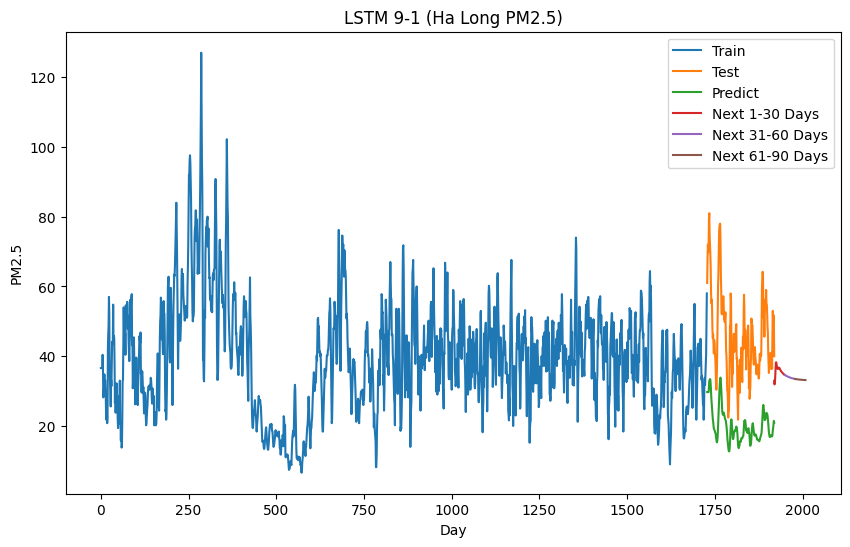

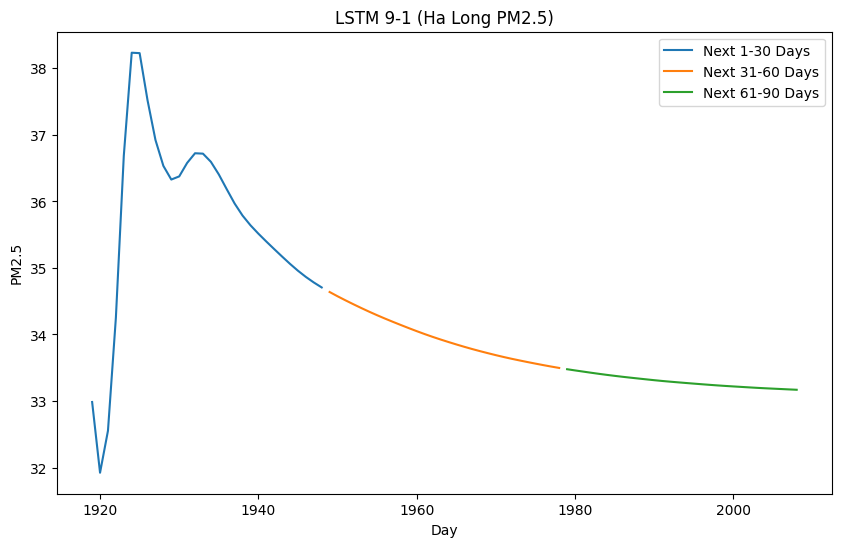

In [9]:
# 14.Vẽ hình
plt.figure(figsize=(10, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Next 1-30 Days', 'Next 31-60 Days', 'Next 61-90 Days'])
plt.title('LSTM 9-1 (Ha Long PM2.5)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.show()

# Dự đoán 90 ngày tiếp theo
plt.figure(figsize=(10, 6))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Next 1-30 Days', 'Next 31-60 Days', 'Next 61-90 Days'])
plt.title('LSTM 9-1 (Ha Long PM2.5)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.show()

In [10]:
print(scaler.inverse_transform(lst_output))

[[32.98524638]
 [31.92227992]
 [32.55288806]
 [34.25206922]
 [36.68563823]
 [38.23517174]
 [38.22908615]
 [37.51991438]
 [36.92382113]
 [36.53424491]
 [36.32888866]
 [36.37611116]
 [36.57851433]
 [36.7241737 ]
 [36.7181527 ]
 [36.59559774]
 [36.40642427]
 [36.18454436]
 [35.96859215]
 [35.78760157]
 [35.64173946]
 [35.51557478]
 [35.39776163]
 [35.28355282]
 [35.17101432]
 [35.0613105 ]
 [34.9583507 ]
 [34.86521719]
 [34.78207501]
 [34.70720543]
 [34.63859906]
 [34.57452816]
 [34.5136418 ]
 [34.45483659]
 [34.39770707]
 [34.34249724]
 [34.28960359]
 [34.23885747]
 [34.18996646]
 [34.14234567]
 [34.09570087]
 [34.05031552]
 [34.00657178]
 [33.96493611]
 [33.92533674]
 [33.88740229]
 [33.85073448]
 [33.81537995]
 [33.78161499]
 [33.74955443]
 [33.71891838]
 [33.68939826]
 [33.6611968 ]
 [33.63470154]
 [33.60975099]
 [33.58568673]
 [33.5622522 ]
 [33.53952454]
 [33.51776929]
 [33.49717482]
 [33.47801563]
 [33.46008001]
 [33.44276695]
 [33.42563509]
 [33.4090594 ]
 [33.39331797]
 [33.37841